In [52]:
import pandas as pd
import json

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter

import math

In [11]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
  'font.size': 8,
  'text.usetex': True,
  'text.latex.preamble': r'\usepackage{amsmath}',
  'pgf.texsystem': "pdflatex",
  'pgf.preamble': r'\usepackage{amsfonts}',
  #"font.family": "serif",
  #"pgf.rcfonts": False,
})

In [2]:
fig_width=6
fig_height=1.5

In [3]:
color_i = 0
colors = {}
def get_color(fun):
    global color_i
    global colors
    
    key = fun.lower()
    if key not in colors:
        options = list(mcolors.TABLEAU_COLORS) + list(mcolors.BASE_COLORS)[0:-1]
        colors[key] = options[color_i % len(options)]
        color_i += 1
    return colors[key]

def reset_colors():
    global color_i
    global colors
    color_i = 0
    colors = {}

In [4]:
results_file = f"../results.json"
with open (results_file) as file:
    data = json.load(file)
    df = pd.json_normalize(data, "benchmarks")

In [78]:
def dataset_name(d):
    return {'books': "amazon", 
            'fb': "facebook", 
            'gap_10': "gapped 10%",
            'osm': "open street map",
            'seq': "sequential",
            'normal': "normal",
            'uniform': "uniform",
            'wiki': "wikipedia"}[d]

def dataset_order(d):
    return {n: i for i, n in enumerate([
            'sequential', 
            'gapped 10%',
            'normal',
            'uniform',
            'amazon',
            'wikipedia',
            'facebook',
            'open street map'
        ])}[d]

def function_name(f):
    return {
        'DoNothing64': "DoNothing",
        'cht_64_128': "CHT ($\epsilon=128$)",
        'cht_64_16': "CHT ($\epsilon=16$)",
        'cht_64_4': "CHT ($\epsilon=4$)",
        'pgm_hash_eps128_epsrec128': "PGM ($\epsilon=128$)",
        'pgm_hash_eps16_epsrec16': "PGM ($\epsilon=16$)",
        'pgm_hash_eps4_epsrec4': "PGM ($\epsilon=4$)",
        'radix_spline_err128_rbits18': "RadixSpline ($\epsilon=128, r=18$)",
        'radix_spline_err16_rbits18': "RadixSpline ($\epsilon=16, r=18$)",
        'radix_spline_err4_rbits18': "RadixSpline ($\epsilon=4, r=18$)",
        'rmi_hash_100': "RMI ($\leq 10^2$)",
        'rmi_hash_10000': "RMI ($\leq 10^4$)",
        'rmi_hash_1000000': "RMI ($\leq 10^6$)",
        'trie_spline_err128': "PLEX ($\epsilon=128$)",
        'trie_spline_err16': "PLEX ($\epsilon=16$)",
        'trie_spline_err4': "PLEX ($\epsilon=4$)"
    }[f]

def do_order(f):
    return {n: i for i, n in enumerate([
        'rmi_hash_100',
        'rmi_hash_10000',
        'rmi_hash_1000000',
        'pgm_hash_eps128_epsrec128',
        'pgm_hash_eps16_epsrec16',
        'pgm_hash_eps4_epsrec4',
        'radix_spline_err128_rbits18',
        'radix_spline_err16_rbits18',
        'radix_spline_err4_rbits18',
        'trie_spline_err128',
        'trie_spline_err16',
        'trie_spline_err4',
        'cht_64_128',
        'cht_64_16',
        'cht_64_4',
    ])}[f]

def probing_dist(internal_id):
    return {0: 'uniform', 1: 'exponential'}[int(internal_id)]

def round_to_nearest_pow_10(num):
    next_smallest = 10**math.floor(math.log10(num))
    return next_smallest * math.ceil(float(num) / float(next_smallest))

In [79]:
raw_func_key = "raw_func_name"
# func_key = "func_name"
dataset_key = "dataset"
dataset_size_key = "dataset_size"
rounded_dataset_size_key = "rounded_dataset_size"
probing_dist_key = "probing_dist"
dataset_order_key = "ds_order"
ns_per_key = "ns_per_key"
throughput_key = "throughput" 
order_key = "order"
hashfn_bytes_key = "hashfn_byte_size"
hashfn_bits_per_key = "hashfn_bits_per_key"
sample_size_key = "sample_size"

th_df = df[(df["name"].str.startswith("BM_build_and_throughput")) & (df["run_type"] == "aggregate") & (df["aggregate_name"] == "median")].copy(deep=True)
th_df[raw_func_key] = th_df["label"].apply(lambda x : x.split(":")[0])
# th_df[func_key] = th_df[raw_func_key].apply(function_name)
th_df[dataset_key] = th_df["label"].apply(lambda x : dataset_name(x.split(":")[1]))
th_df[rounded_dataset_size_key] = th_df[dataset_size_key].apply(round_to_nearest_pow_10)
th_df[dataset_order_key] = th_df[dataset_key].apply(dataset_order)
th_df[probing_dist_key] = th_df["name"].apply(lambda x : probing_dist(x.split("/")[4]))
th_df[sample_size_key] = th_df["name"].apply(lambda x : int(x.split("/")[3]))
empty_th_loop_overhead = th_df[th_df[raw_func_key].str.startswith("DoNothing")].agg({"cpu_time": 'mean'}).values[0]
th_df = th_df[~th_df[raw_func_key].str.startswith("DoNothing")]
th_df[ns_per_key] = th_df.apply(lambda x : x["cpu_time"] - empty_th_loop_overhead, axis=1)
th_df[throughput_key] = th_df["cpu_time"].apply(lambda x : 10**9 / x)
th_df[hashfn_bits_per_key] = th_df.apply(lambda x : x[hashfn_bytes_key] / x[dataset_size_key], axis=1)
th_df[order_key] = th_df[raw_func_key].apply(do_order)
th_df = th_df.sort_values(by=[order_key])

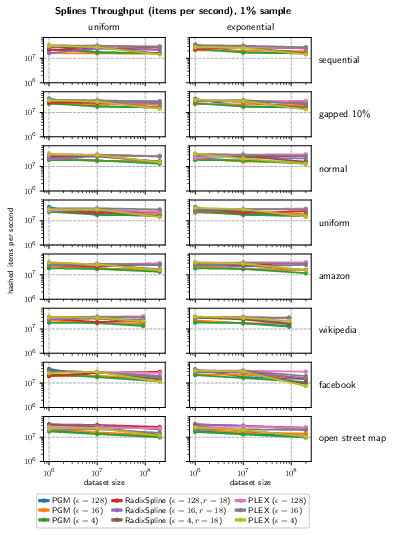

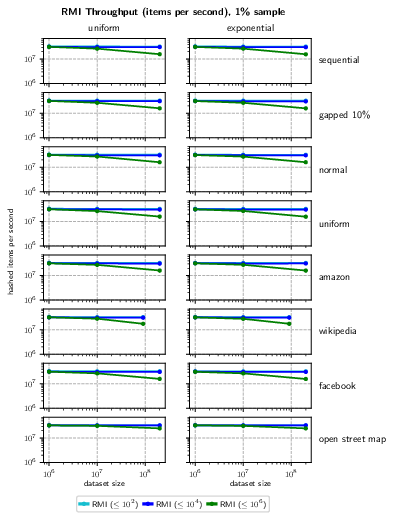

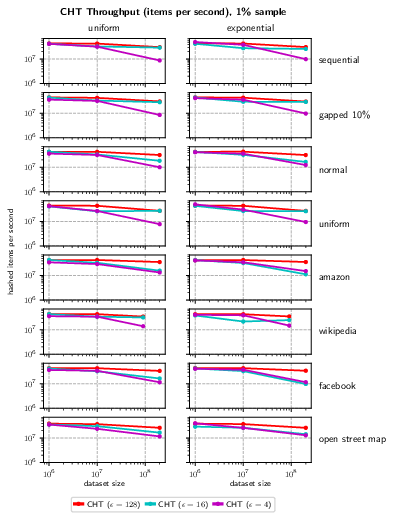

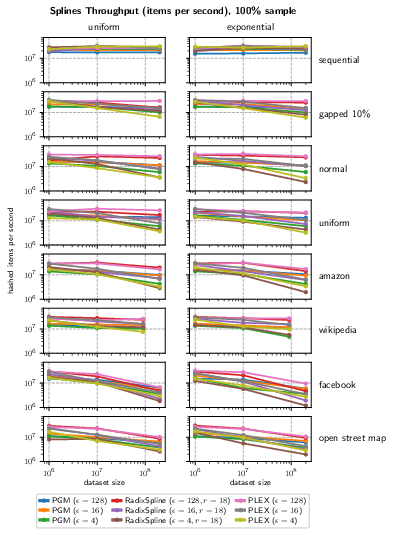

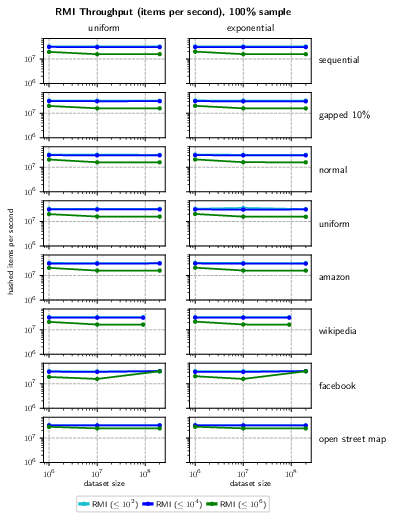

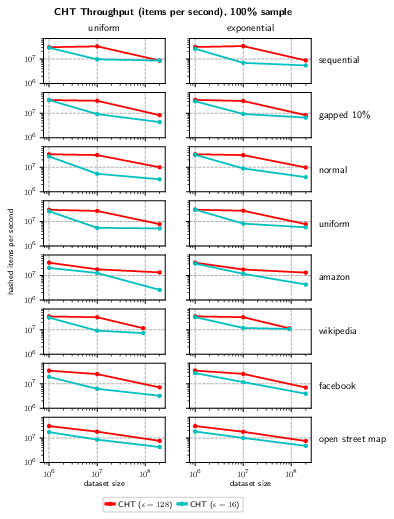

In [80]:
def plot_throughput_deterioration(data, title, sample_size, off=(0.5, 0.03), onlyplot=None):
    dists = set(data[probing_dist_key])
    
    rows = 8
    cols = len(dists)
    
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width*0.8, rows*fig_height*0.65), sharex=True, sharey=True)

    data = data[data[sample_size_key] == sample_size].sort_values(by=[dataset_order_key, rounded_dataset_size_key])
    for i, (dataset, df) in enumerate(data.groupby([dataset_key], sort=False)):
        pad = 7.5
        axs[i][-1].annotate(
            dataset, 
            xy=(0, 0.5),
            xytext=(125 + axs[i][-1].yaxis.labelpad + pad, 0),
            xycoords=axs[i][-1].yaxis.label, 
            textcoords='offset points',
            size='large', 
            ha='left', 
            va='center',
            rotation=0
        )
        for j, (probing_dist, df) in enumerate(df.groupby([probing_dist_key], sort=False)):            
            ax = axs[i][j]

            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylim([10**6, 7*10**7])
            # ax.set_xticks([10**i for i in [4, 5, 6, 7, 8, 9]])
            if i == rows - 1:
                ax.set_xlabel("dataset size")
            ax.grid(linestyle="--", axis="both")
    
            for k, (raw_name, df) in enumerate(df.groupby([raw_func_key], sort=False)):
                if onlyplot != None and raw_name not in onlyplot:
                    continue
                ax.plot(dataset_size_key, throughput_key, data=df, color=get_color(raw_name), label=function_name(raw_name), linewidth=1.5, marker='.')
                
            if i == 0:
                # ax.set_ylabel("normalized entries per slot")
                ax.annotate(probing_dist, 
                            xy=(0.5, 1), 
                            xytext=(0, pad), 
                            xycoords='axes fraction', 
                            textcoords='offset points', 
                            size='large', 
                            ha='center', 
                            va='baseline',
                           )

    h, l = axs[0][0].get_legend_handles_labels()
    legend = fig.legend(h, l, 
               loc='lower center',
               bbox_to_anchor=off,
               ncol=3,
               borderpad=0.4, 
               labelspacing=0.2, 
               handlelength=1.0, 
               handletextpad=0.5, 
               columnspacing=0.7
              )
    for line in legend.get_lines():
        line.set_linewidth(3.0)
                
    # overall title
    fig.suptitle(f"{title} Throughput (items per second), {sample_size}% sample", y=0.935, fontweight="bold")
    fig.text(0.02, 0.5, 'hashed items per second', va='center', rotation='vertical')
    
    fig.savefig(f"throughput_deterioration_{title.casefold()}_sample_{sample_size}.pdf", bbox_inches="tight", dpi=300)
    fig.savefig(f"throughput_deterioration_{title.casefold()}_sample_{sample_size}.pgf", bbox_inches="tight", dpi=300)

reset_colors()
for sample_size in [1, 100]:
    plot_throughput_deterioration(th_df, "Splines", sample_size=sample_size, off=(0.5, 0.0), onlyplot=[
        'pgm_hash_eps128_epsrec128',
        'pgm_hash_eps16_epsrec16',
        'pgm_hash_eps4_epsrec4',
        'radix_spline_err128_rbits18',
        'radix_spline_err16_rbits18',
        'radix_spline_err4_rbits18',
        'trie_spline_err128',
        'trie_spline_err16',
        'trie_spline_err4'
    ])
    plot_throughput_deterioration(th_df, "RMI", sample_size=sample_size, onlyplot=["rmi_hash_1000000", "rmi_hash_10000", "rmi_hash_100"])
    plot_throughput_deterioration(th_df, "CHT", sample_size=sample_size, onlyplot=['cht_64_128', 'cht_64_16', 'cht_64_4'])
    

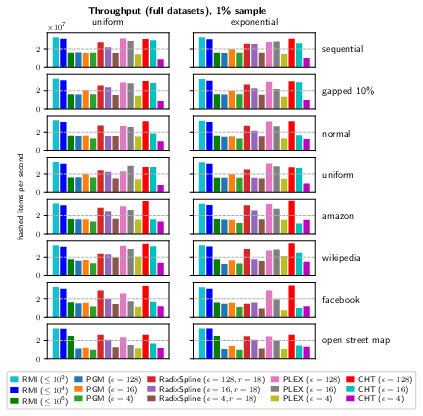

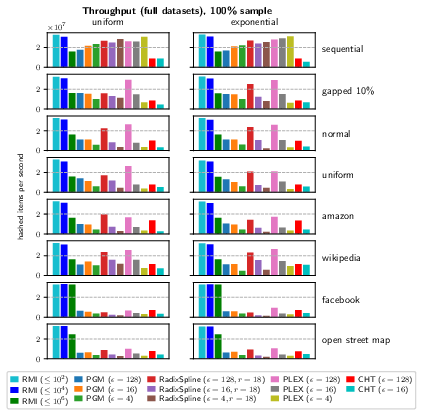

In [87]:
def plot_throughput(data, sample):
    dists = set(data[probing_dist_key])
    
    rows = 8
    cols = len(dists)
    
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width*0.8, rows*fig_height*0.5), sharex=True, sharey=True)

    data = data[(data[dataset_size_key] > 10**7) & (data[sample_size_key] == sample)].copy(deep=True).sort_values(by=[dataset_order_key, order_key])
    for i, (dataset, df) in enumerate(data.groupby([dataset_key], sort=False)):
        pad = 7.5
        axs[i][-1].annotate(
            dataset, 
            xy=(0, 0.5),
            xytext=(125 + axs[i][-1].yaxis.labelpad + pad, 0),
            xycoords=axs[i][-1].yaxis.label, 
            textcoords='offset points',
            size='large', 
            ha='left', 
            va='center',
            rotation=0
        )
        for j, (probing_dist, df) in enumerate(df.groupby([probing_dist_key], sort=False)):            
            ax = axs[i][j]
    
            for k, (name, df) in enumerate(df.groupby([raw_func_key], sort=False)):
                # print(name, df[throughput_key])
                ax.bar(data=df, x=order_key, height=throughput_key, label=function_name(name), color=get_color(name))

            ax.tick_params(
                axis='x',
                which='both',
                top=False, 
                bottom=False, 
                labelbottom=False
            )

            if i > 0:
                ax.yaxis.offsetText.set_visible(False)
            ax.grid(linestyle="--", axis="y", which="major")
    
            if i == 0:
                ax.annotate(
                    probing_dist, 
                    xy=(0.5, 1), 
                    xytext=(0, pad), 
                    xycoords='axes fraction', 
                    textcoords='offset points', 
                    size='large', 
                    ha='center', 
                    va='baseline',
                )

    h, l = axs[0][0].get_legend_handles_labels()
    legend = fig.legend(h, l, 
               loc='lower center',
               bbox_to_anchor=(0.6, 0.0),
               ncol=5,
               borderpad=0.4, 
               labelspacing=0.2, 
               handlelength=1.0, 
               handletextpad=0.5, 
               columnspacing=0.7
              )
    
    # overall title
    fig.suptitle(f"Throughput (full datasets), {sample}% sample", y=0.94, fontweight="bold")
    fig.text(0.04, 0.5, 'hashed items per second', va='center', rotation='vertical')
    
    fig.savefig(f"throughput_{sample}.pdf", bbox_inches="tight", dpi=300)
    fig.savefig(f"throughput_{sample}.pgf", bbox_inches="tight", dpi=300)

plot_throughput(th_df, sample=1)
plot_throughput(th_df, sample=100)

In [ ]:
def plot_build_time(data):
    rows = 8
    cols = 2
    
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width*0.8, rows*fig_height*0.6), sharex=True, sharey=True)

    data = data[data[dataset_size_key] >= 10**8].copy(deep=True).sort_values(by=[dataset_order_key, order_key])
    for i, (dataset, df) in enumerate(data.groupby([dataset_key], sort=False)):
        pad = 7.5
        axs[i][-1].annotate(
            dataset, 
            xy=(0, 0.5),
            xytext=(125 + axs[i][-1].yaxis.labelpad + pad, 0),
            xycoords=axs[i][-1].yaxis.label, 
            textcoords='offset points',
            size='large', 
            ha='left', 
            va='center',
            rotation=0
        )
        
        for j, (presorted, df) in enumerate(df.groupby([presorted_key], sort=False)):            
            ax = axs[i][j]

            ax.set_yscale('log')
            ax.set_yticks([10**i for i in [5, 6, 7, 8, 9]])
            ax.set_ylim([5 * 10**4, 2 * 10**9])
            ax.grid(linestyle="--", axis="y", which="major")
    
            for name, df in df.groupby([func_key], sort=False):
                if name == "DoNothingHash":
                    continue
                ax.bar(data=df, x=df[order_key].values[0]-1, height=throughput_key, label=function_name(name, params=True), color=get_color(name))
                
            if i == 0:
                ax.annotate(
                    "Presorted" if presorted else "Unsorted", 
                    xy=(0.5, 1), 
                    xytext=(0, pad), 
                    xycoords='axes fraction', 
                    textcoords='offset points', 
                    size='large', 
                    ha='center', 
                    va='baseline',
                )
                
            ax.tick_params(
                axis='x',
                which='both',
                top=False, 
                bottom=False, 
                labelbottom=False
            )

    h, l = axs[0][0].get_legend_handles_labels()
    legend = fig.legend(h, l, 
               loc='lower center',
               bbox_to_anchor=(0.5, 0.01),
               ncol=3,
               borderpad=0.4, 
               labelspacing=0.2, 
               handlelength=1.0, 
               handletextpad=0.5, 
               columnspacing=0.7
              )
    for line in legend.get_lines():
        line.set_linewidth(3.0)
                
    # overall title
    fig.suptitle(f"Build time (full datasets)", y=0.93, fontweight="bold")
    fig.text(0.04, 0.5, 'ingested items per second', va='center', rotation='vertical')
    
    fig.savefig(f"build.pdf", bbox_inches="tight", dpi=300)
    fig.savefig(f"build.pgf", bbox_inches="tight", dpi=300)

plot_build_time(bt_df)

In [ ]:
def plot_space_vs_time(data, title=None, xmax=None, ymax=None, yticks=None):
    dists = set(data[probing_dist_key])
    
    rows = 8
    cols = len(dists)
    
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width*0.8, rows*fig_height*0.5), sharex=True, sharey=True)

    data = data[data[dataset_size_key] > 10**7].copy(deep=True).sort_values(by=[dataset_order_key, order_key])
    for i, (dataset, df) in enumerate(data.groupby([dataset_key], sort=False)):
        pad = 7.5
        axs[i][-1].annotate(
            dataset, 
            xy=(0, 0.5),
            xytext=(125 + axs[i][-1].yaxis.labelpad + pad, 0),
            xycoords=axs[i][-1].yaxis.label, 
            textcoords='offset points',
            size='large', 
            ha='left', 
            va='center',
            rotation=0
        )
        
        for j, (probing_dist, df) in enumerate(df.groupby([probing_dist_key], sort=False)):            
            ax = axs[i][j]
    
            for name, df in df.groupby([func_key], sort=False):
                if name == "DoNothingHash":
                    continue
                ax.scatter(x=df[hashfn_bits_key], y=df["cpu_time"], label=function_name(name, params=True), color=get_color(name), marker='x', s=14)

            if xmax != None:
                ax.set_xlim([0, xmax])
            if ymax != None:
                ax.set_ylim([0, ymax])
            if yticks != None:
                ax.set_yticks(yticks)

            ax.grid(linestyle="--", axis="both")
            ax.set_xlabel("bits per key")
    
            if i == 0:
                ax.annotate(
                    probing_dist, 
                    xy=(0.5, 1), 
                    xytext=(0, pad), 
                    xycoords='axes fraction', 
                    textcoords='offset points', 
                    size='large', 
                    ha='center', 
                    va='baseline',
                )

    h, l = axs[0][0].get_legend_handles_labels()
    legend = fig.legend(h, l, 
               loc='lower center',
               bbox_to_anchor=(0.5, -0.05),
               ncol=3,
               borderpad=0.4, 
               labelspacing=0.2, 
               handlelength=1.0, 
               handletextpad=0.5, 
               columnspacing=0.7
              )
    
    # overall title
    fig.suptitle(f"{f'{title.capitalize()} ' if title != None else ''} Space vs. Latency (full datasets)", y=0.94, fontweight="bold")
    fig.text(0.03, 0.5, 'nanoseconds per key', va='center', rotation='vertical')
    
    fig.savefig(f"pareto{f'_{title}' if title != None else ''}.pdf", bbox_inches="tight", dpi=300)
    fig.savefig(f"pareto{f'_{title}' if title != None else ''}.pgf", bbox_inches="tight", dpi=300)
    return

plot_space_vs_time(pareto_df, yticks=[0, 500, 1000, 1500])
plot_space_vs_time(pareto_df, title='zoomed', xmax=40, ymax=350, yticks=[0, 100, 200, 300])